In [2]:
import io
import os
import zipfile
import pickle
from urllib.request import urlopen
from urllib.parse import urlparse

import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

In [3]:
def fetch_speeches(years):
    paths = ['https://bis.org/speeches/speeches_' + str(year) + '.zip' for year in years]
    speeches = pd.DataFrame()

    for path in paths:
        remotezip = urlopen(path) # read the zip file as a string
        zipinmemory = io.BytesIO(remotezip.read()) # convert from a string to bytes
        zip = zipfile.ZipFile(zipinmemory) # pass the bytes to python's zipfile handler
        
        # read the excel spreadsheet
        xlsx_path = zip.namelist()[0] # get the name of the excel file
        with zip.open(xlsx_path) as f:
            data = pd.read_csv(f)

        data['id'] = [('').join(os.path.basename(urlparse(url).path).split('.')[:-1]) for url in data['url']]   
        speeches = pd.concat([speeches, data])
    return speeches

def summation_score(classifier, weight):
   classifier[classifier > 0] *= weight
   try:
      score = sum(classifier) / len(classifier)
      return score
   except:
      return np.nan


In [5]:
with open('climatebert_parameters.pkl', 'rb') as f:
    parameters = pickle.load(f)

In [16]:
data = pd.read_csv('climatebert_speeches.csv')
unweighted_scores = [summation_score(parameters[key], 1) for key in parameters.keys()]
data['unweighted_scores'] = unweighted_scores
data['probability_score'] = 0.5*(data['unweighted_scores'] + 1)

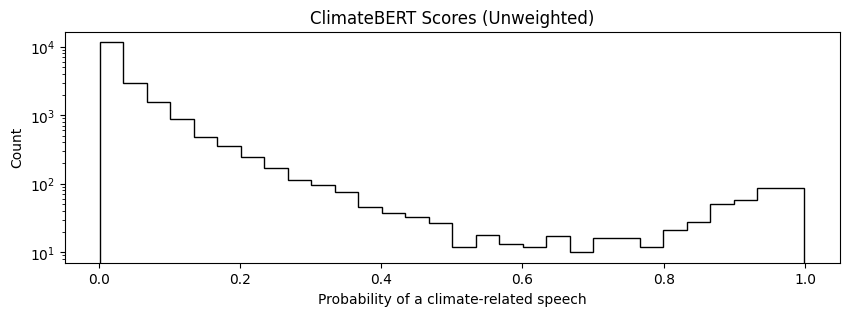

In [23]:
plt.figure(figsize=(10,3))
plt.title(r'ClimateBERT Scores (Unweighted)')
plt.hist(data['probability_score'], color = 'k', histtype='step', bins=30)
plt.xlabel('Probability of a climate-related speech')
plt.ylabel('Count')
plt.yscale('log')

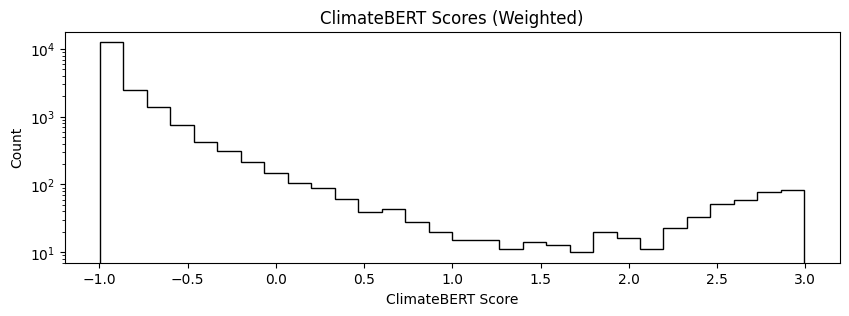

In [19]:
plt.figure(figsize=(10,3))
plt.title(r'ClimateBERT Scores (Weighted)')
plt.hist(data['climatebert_scores'], color = 'k', histtype='step', bins=30)
plt.xlabel('ClimateBERT Score')
plt.ylabel('Count')
plt.yscale('log')

In [20]:
climate_mask = np.all([data['unweighted_scores'] > 0], axis=0)

print(len(data[climate_mask]))

458


In [15]:
climate_speeches.head()

,Unnamed: 0,url,title,description,date,author,id,climatebert_scores,unweighted_scores
712,21,https://www.bis.org/review/r001129c.pdf,Environmental issues and their implications fo...,"Keynote Speech by Mr David Carse, Deputy Chief...",2000-11-29 00:00:00,David Carse,r001129c,2.994957,0.998319
1125,136,https://www.bis.org/review/r010629a.pdf,Alan Greenspan: Impact of energy on the economy,"Remarks by Mr Alan Greenspan, Chairman of the ...",2001-06-28 00:00:00,Alan Greenspan,r010629a,2.462214,0.769327
2003,26,https://www.bis.org/review/r041229a.pdf,Jean-Pierre Roth: International monetary polic...,"Summary of a speech by Mr Jean Pierre Roth, Ch...",2004-12-06 00:00:00,Jean-Pierre Roth,r041229a,2.321586,0.773862
2006,29,https://www.bis.org/review/r041223g.pdf,Caleb M Fundanga: Economic and environmental g...,"Speech by Dr Caleb M Fundanga, Governor of the...",2004-11-03 00:00:00,Caleb M Fundanga,r041223g,2.889234,0.951796
2055,78,https://www.bis.org/review/r041122c.pdf,Philipp M Hildebrand: Monetary policy and oil ...,"Speech by Mr Philipp M Hildebrand, Member of t...",2004-11-18 00:00:00,Philipp Hildebrand,r041122c,1.506405,0.286226
